# Fuzzy C-Means

## Synthetic Data

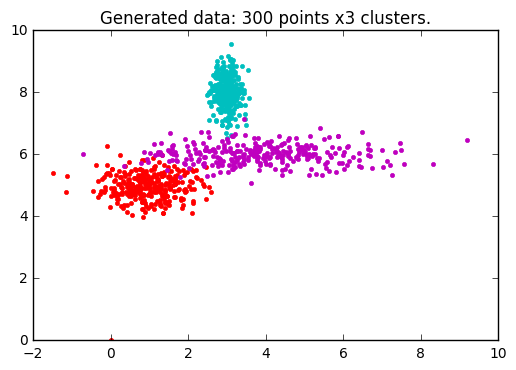

In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
#import skfuzzy as fuzz
%matplotlib inline
colors = ['r', 'c', 'm', 'y', 'k', 'Brown', '0.75','b', 'orange', 'g']

# Define three cluster centers
centers = [[1, 5],
           [3, 8],
           [4, 6]]

# Define three cluster sigmas in x and y, respectively
sigmas = [[0.7, 0.4],
          [0.2, 0.5],
          [1.6, 0.3]]

# Generate test data
np.random.seed(19)  # Set seed for reproducibility
xpts = np.zeros(1)
ypts = np.zeros(1)
labels = np.zeros(1)
for i, ((xmu, ymu), (xsigma, ysigma)) in enumerate(zip(centers, sigmas)):
    xpts = np.hstack((xpts, np.random.standard_normal(300) * xsigma + xmu))
    ypts = np.hstack((ypts, np.random.standard_normal(300) * ysigma + ymu))
    labels = np.hstack((labels, np.ones(300) * i))

# Visualize the test data
fig0, ax0 = plt.subplots()
for label in range(3):
    ax0.plot(xpts[labels == label], ypts[labels == label], '.',
             color=colors[label])
ax0.set_title('Generated data: 300 points x3 clusters.')

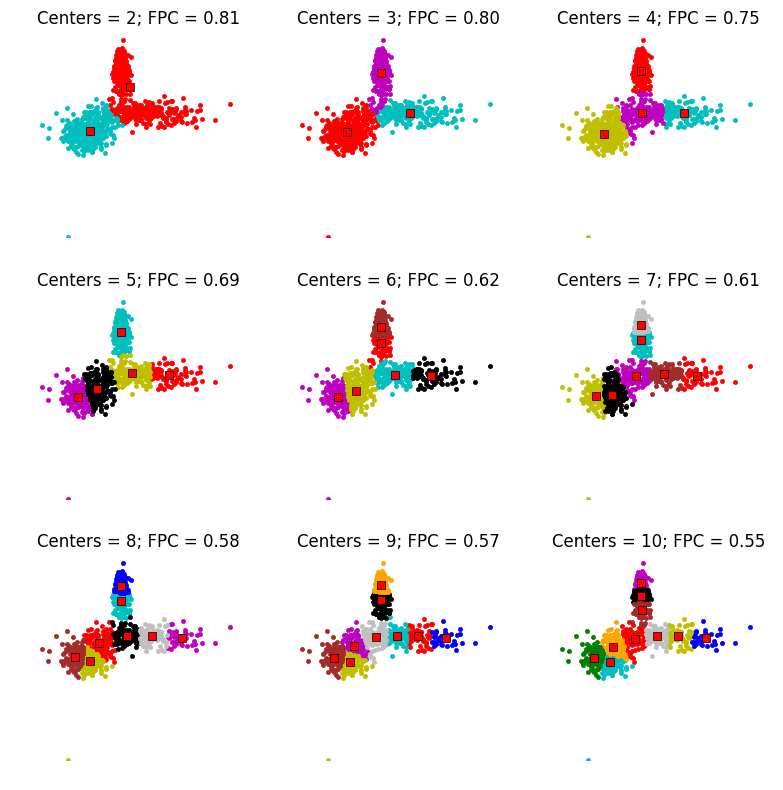

In [2]:
from FCM import FuzzyCMeans
# Set up the loop and plot
fig1, axes1 = plt.subplots(3, 3, figsize=(8, 8))
alldata = np.vstack((xpts, ypts))

fpcs = []

for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    fcm = FuzzyCMeans(ncenters, 2, error=0.005, max_iterations=1000)
    cntr, u, u0, d, fpc = fcm.fit(alldata)

    # Store fpc values for later
    fpcs.append(fpc)

    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(xpts[cluster_membership == j],
                ypts[cluster_membership == j], '.', color=colors[j])

    # Mark the center of each fuzzy cluster
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
    ax.axis('off')

fig1.tight_layout()

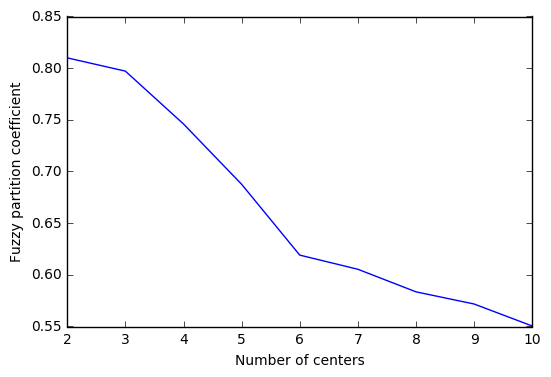

In [3]:
fig2, ax2 = plt.subplots()
ax2.plot(np.r_[2:11], fpcs)
ax2.set_xlabel("Number of centers")
ax2.set_ylabel("Fuzzy partition coefficient")

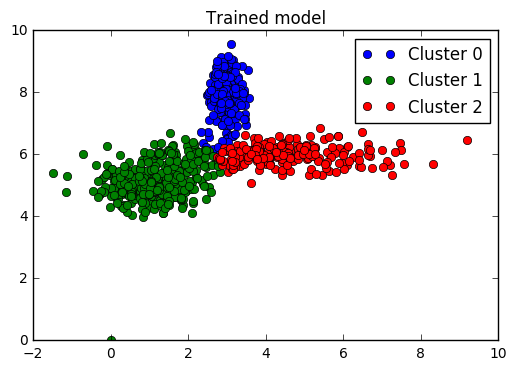

In [4]:
# Regenerate fuzzy model with 3 cluster centers - note that center ordering
# is random in this clustering algorithm, so the centers may change places
fcm = FuzzyCMeans(c=3,m=2,error=0.005,max_iterations=1000)
cntr, u, u0, d, fpc = fcm.fit(alldata)

# Show 3-cluster model
fig2, ax2 = plt.subplots()
ax2.set_title('Trained model')
for j in range(3):
    ax2.plot(alldata[0, u.argmax(axis=0) == j],
             alldata[1, u.argmax(axis=0) == j], 'o',
             label='Cluster ' + str(j))
ax2.legend()

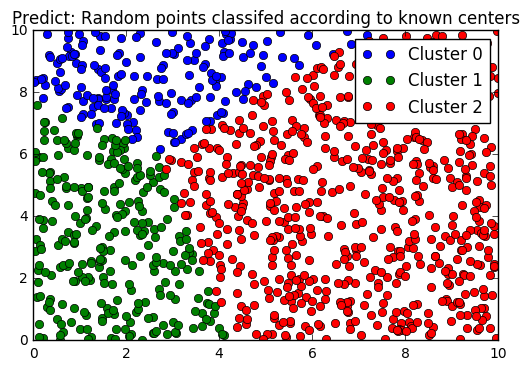

In [5]:
# Generate uniformly sampled data spread across the range [0, 10] in x and y
newdata = np.random.uniform(0, 1, (1100, 2)) * 10

# Predict new cluster membership with `cmeans_predict` as well as
# `cntr` from the 3-cluster model
fcm = FuzzyCMeans(m=2, error=0.005, max_iterations=1000)
u, u0, d, fpc = fcm.predict(newdata.T, cntr)

# Plot the classified uniform data. Note for visualization the maximum
# membership value has been taken at each point (i.e. these are hardened,
# not fuzzy results visualized) but the full fuzzy result is the output
# from cmeans_predict.
cluster_membership = np.argmax(u, axis=0)  # Hardening for visualization

fig3, ax3 = plt.subplots()
ax3.set_title('Predict: Random points classifed according to known centers')
for j in range(3):
    ax3.plot(newdata[cluster_membership == j, 0],
             newdata[cluster_membership == j, 1], 'o',
             label='Cluster ' + str(j))
ax3.legend()

plt.show()

In [6]:
newdata.shape

(1100, 2)

# Real Data: MNIST

In [7]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)

digits = load_digits()
data = scale(digits.data)

n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target

sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


print(79 * '_')
print('% 9s' % 'init'
      '    time  inertia    homo   compl  v-meas     ARI AMI  silhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('% 9s   %.2fs    %i   %.3f   %.3f   %.3f   %.3f   %.3f    %.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)

n_digits: 10, 	 n_samples 1797, 	 n_features 64
_______________________________________________________________________________
init    time  inertia    homo   compl  v-meas     ARI AMI  silhouette
k-means++   0.27s    69432   0.602   0.650   0.625   0.465   0.598    0.146
   random   0.22s    69694   0.669   0.710   0.689   0.553   0.666    0.147
PCA-based   0.04s    70804   0.671   0.698   0.684   0.561   0.668    0.118


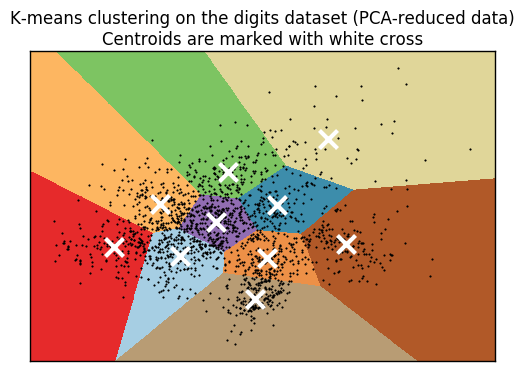

In [8]:
reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

# Fuzzy C-means

0.455216748244


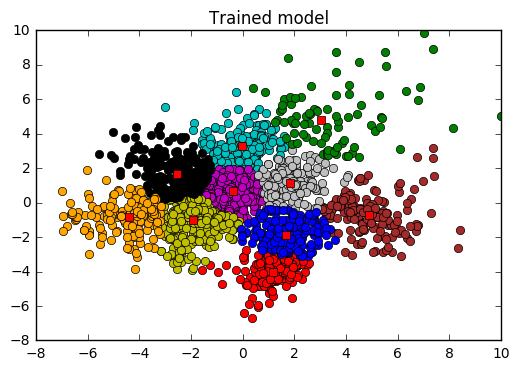

In [15]:
# Regenerate fuzzy model with 3 cluster centers - note that center ordering
# is random in this clustering algorithm, so the centers may change places
fcm = FuzzyCMeans(c=10,m=2,error=0.005,max_iterations=1000)
cntr, u, u0, d, fpc = fcm.fit(data)
data = reduced_data.T
# Show 3-cluster model
fig2, ax2 = plt.subplots()
ax2.set_title('Trained model')
for j in range(10):
    ax2.plot(data[0, u.argmax(axis=0) == j],
             data[1, u.argmax(axis=0) == j], 'o',
             label='Cluster ' + str(j),
             color=colors[j])
for pt in cntr:
    ax2.plot(pt[0], pt[1], 'rs')
#ax2.legend()
print (fpc)

In [16]:
fpc

0.45521674824397729

In [17]:
np.min(reduced_data),np.max(reduced_data)

(-6.9972151814046759, 9.9825083204042357)

In [18]:
u.argmax(axis=0)

array([7, 2, 6, ..., 6, 7, 3])

In [19]:
u

array([[ 0.05258775,  0.01742977,  0.04788384, ...,  0.04234248,
         0.05004037,  0.09836354],
       [ 0.02417364,  0.07187215,  0.04462766, ...,  0.04928452,
         0.04527594,  0.02814052],
       [ 0.06591335,  0.43770438,  0.17098155, ...,  0.23744838,
         0.20263234,  0.09695   ],
       ..., 
       [ 0.59201417,  0.04888795,  0.26391574, ...,  0.19206273,
         0.26444733,  0.10527555],
       [ 0.01333601,  0.01565578,  0.02037924, ...,  0.02162553,
         0.02233617,  0.07724058],
       [ 0.01536127,  0.02072563,  0.02271822, ...,  0.02247964,
         0.02182394,  0.01337268]])

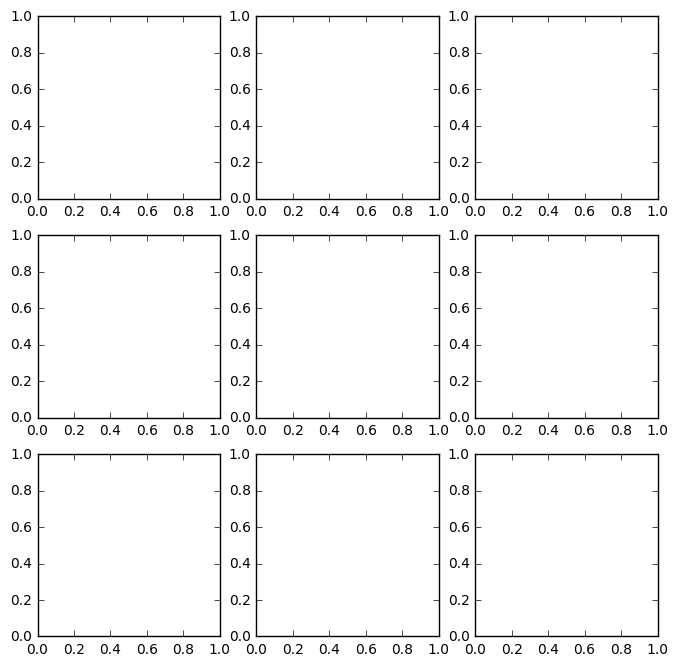

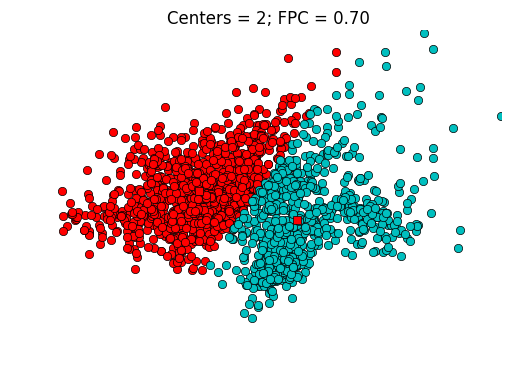

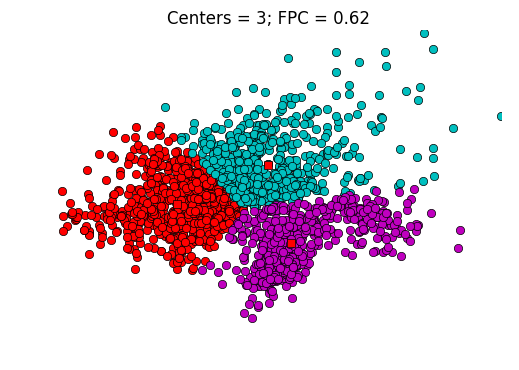

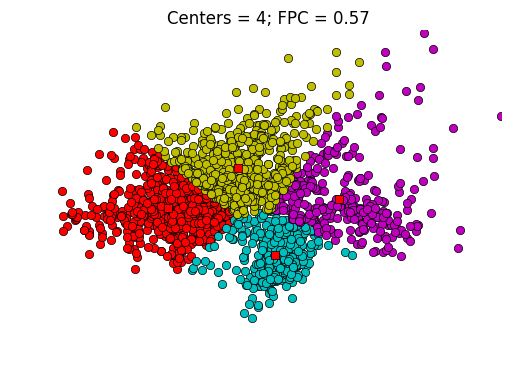

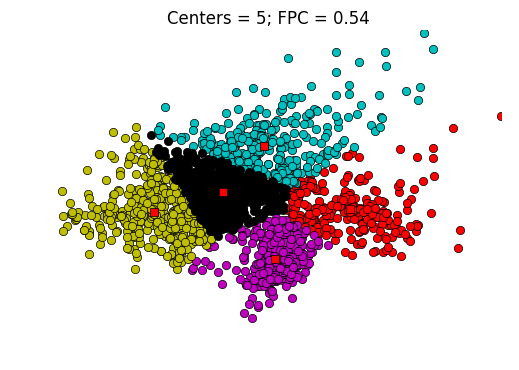

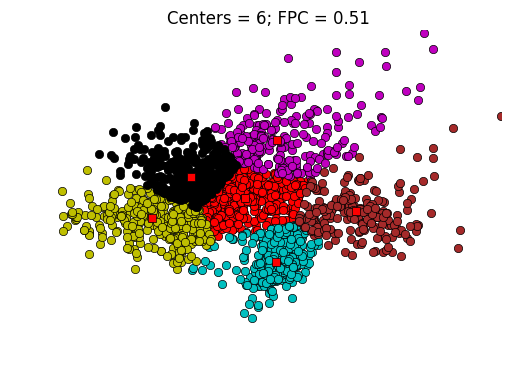

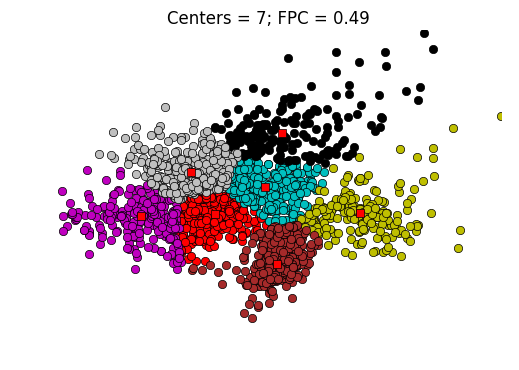

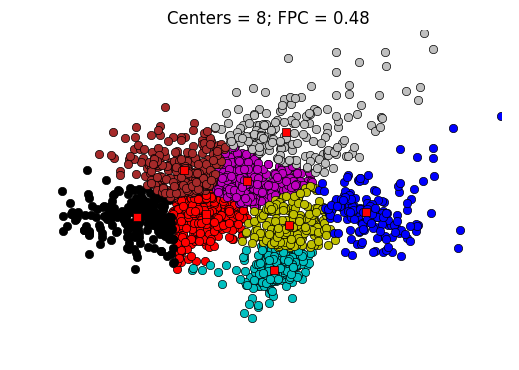

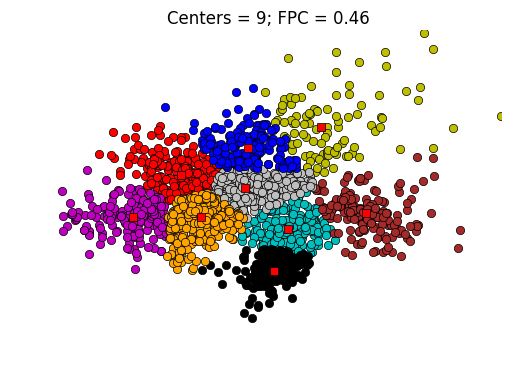

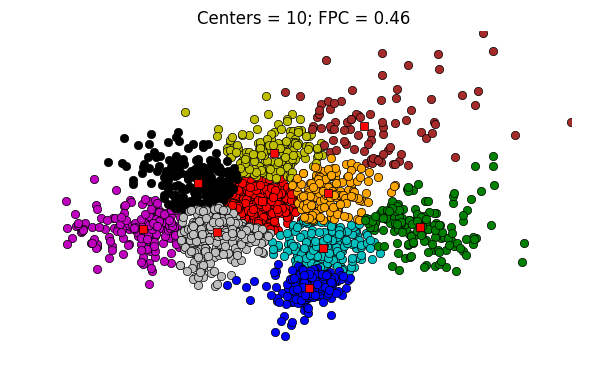

In [26]:
from FCM import FuzzyCMeans
# Set up the loop and plot
fig1, ax = plt.subplots(3, 3, figsize=(8, 8))
data = reduced_data.T
fpcs = []

for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    fcm = FuzzyCMeans(c=ncenters,m=2,error=0.005,max_iterations=1000)
    cntr, u, u0, d, fpc = fcm.fit(data)
    data = reduced_data.T
    # Show 3-cluster model
    fig1, ax = plt.subplots()
    ax.set_title('Trained model')
    for j in range(10):
        ax.plot(data[0, u.argmax(axis=0) == j],
                 data[1, u.argmax(axis=0) == j], 'o',
                 label='Cluster ' + str(j),
                 color=colors[j])
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')
    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
    ax.axis('off')

fig1.tight_layout()